In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.metrics import precision_recall_curve
import xgboost as xgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

## Exploratory Data Analysis (EDA)¶

The data is from a bank marketing campaign.
Following is the description of every column of the dataframe

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

In [3]:
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
19672,35,technician,married,professional.course,no,no,no,cellular,aug,thu,72,2,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,no
18516,49,technician,married,professional.course,unknown,yes,no,telephone,jul,thu,219,12,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
14264,28,admin.,single,high.school,no,no,no,cellular,jul,mon,259,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
1966,54,admin.,married,basic.4y,unknown,no,no,telephone,may,fri,77,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
39537,52,admin.,married,unknown,no,yes,no,cellular,apr,wed,184,2,10,1,success,-1.8,93.749,-34.6,0.654,5008.7,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### What is the distribution of the outcome feature?

The data is imbalanced.

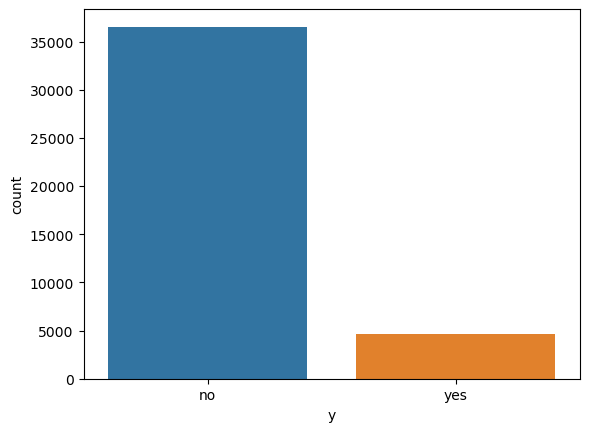

In [5]:
sns.countplot(data=df,x='y')
plt.show()

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df.drop_duplicates(inplace=True)

### Feature engineering

#### Label encoding
For categorical features with low cardinality

In [8]:
le = LabelEncoder()
df.marital = le.fit_transform(df.marital)
df.housing = le.fit_transform(df.housing)
df.y = le.fit_transform(df.y)
df.loan = le.fit_transform(df.loan)
df.default = le.fit_transform(df.default)
df.contact = le.fit_transform(df.contact)
#df.month = le.fit_transform(df.month)
#df.day_of_week = le.fit_transform(df.day_of_week)
df.poutcome = le.fit_transform(df.poutcome)

#### Reducing the memory usage will increase the speed of the computer

In [9]:
def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Starting memory usage: {start_mem:.2f} MB')

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Ending memory usage: {end_mem:.2f} MB')
    print(f'Reduced memory by {(start_mem - end_mem) / start_mem * 100:.1f}%')
    return df

In [10]:
df = reduce_memory(df)

Starting memory usage: 5.81 MB
Ending memory usage: 1.41 MB
Reduced memory by 75.7%


#### How does the correlation looks like now?

There is a good correlation of the outcome and the call duration

<Axes: >

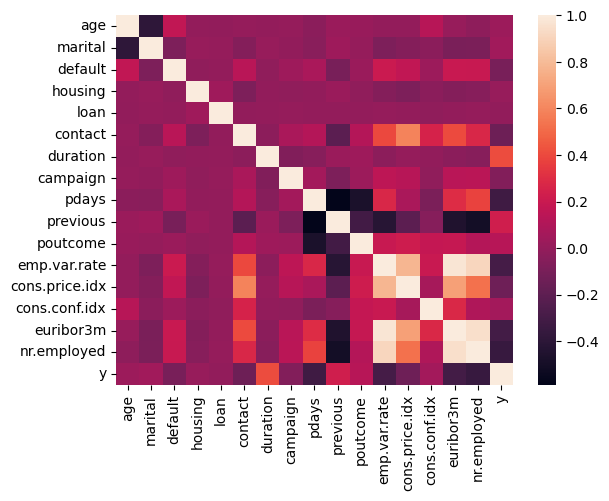

In [11]:
sns.heatmap(df.corr(numeric_only=True))

### Modeling

In [12]:
ct = make_column_transformer(
     (StandardScaler(), ['duration','age','pdays','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']),
     (OneHotEncoder(), ['job','education','month','day_of_week']))

### Model training

#### Model creation
We will try few classifiers: Logistic Regression, Decision Tree Classifier, KNeighbors Claasifier and SVM Classifier.
A Grid search is used to fine tune the classifiers parameters.

#### Classifiers

In [13]:
lr_pipe = Pipeline([('ct', ct), ('model', LogisticRegression(max_iter = 800))])
dt_pipe = Pipeline([('ct', ct), ('model', DecisionTreeClassifier())])
knn_pipe = Pipeline([('ct', ct), ('model', KNeighborsClassifier())])
svc_pipe = Pipeline([('ct', ct), ('model', SVC())])

#### Parameters for tuning

In [14]:
lr_params = {'model__C':[0.1,0.5,1,2],'model__penalty':['l1','l2']
             , 'model__solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
dt_params = {'model__max_depth':[5,6,7,8,9,10], 'model__criterion':['gini', 'entropy', 'log_loss']}
knn_params = {'model__n_neighbors':[5,6,7,8,9,10]}
svc_params = {'model__kernel':['linear','poly','rbf','sigmoid', 'precomputed']}

#### Data split

In [15]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = .33)

### Model training

In [16]:
%%time
lr_search = RandomizedSearchCV(lr_pipe, lr_params).fit(X_train,y_train)
dt_search = RandomizedSearchCV(dt_pipe, dt_params).fit(X_train,y_train)
knn_search = RandomizedSearchCV(knn_pipe, knn_params).fit(X_train,y_train)
svc_search = RandomizedSearchCV(svc_pipe, svc_params).fit(X_train,y_train)

CPU times: total: 12min 7s
Wall time: 2min 51s


In [17]:
#Test scores
test_score =[]
test_score.append(lr_search.score(X_test, y_test))
test_score.append(dt_search.score(X_test, y_test))
test_score.append(knn_search.score(X_test, y_test))
test_score.append(svc_search.score(X_test, y_test))
#Train scores
train_score =[]
train_score.append(lr_search.best_score_)
train_score.append(dt_search.best_score_)
train_score.append(knn_search.best_score_)
train_score.append(svc_search.best_score_)
#Relative time
time_ =[]
time_.append(lr_search.cv_results_['mean_fit_time'].sum())
time_.append(dt_search.cv_results_['mean_fit_time'].sum())
time_.append(knn_search.cv_results_['mean_fit_time'].sum())
time_.append(svc_search.cv_results_['mean_fit_time'].sum())
#precision score
precision =[]
precision.append(precision_score(y_test, lr_search.predict(X_test)))
precision.append(precision_score(y_test, dt_search.predict(X_test)))
precision.append(precision_score(y_test, knn_search.predict(X_test)))
precision.append(precision_score(y_test, svc_search.predict(X_test)))
#recall score
recall =[]
recall.append(recall_score(y_test, lr_search.predict(X_test)))
recall.append(recall_score(y_test, dt_search.predict(X_test)))
recall.append(recall_score(y_test, knn_search.predict(X_test)))
recall.append(recall_score(y_test, svc_search.predict(X_test)))
#f1 score
f1_s =[]
f1_s.append(f1_score(y_test, lr_search.predict(X_test)))
f1_s.append(f1_score(y_test, dt_search.predict(X_test)))
f1_s.append(f1_score(y_test, knn_search.predict(X_test)))
f1_s.append(f1_score(y_test, svc_search.predict(X_test)))
#results data frame
d={'Classifier': ['Logistic Regression','Decision Tree', 'KNN', 'SVC'], 'calculation time': time_
   ,'Training score':train_score,'Testing score':test_score,'precision':precision,'recall':recall,'f1 score':f1_s}
dfp = pd.DataFrame(data = d)
dfp

,Classifier,calculation time,Training score,Testing score,precision,recall,f1 score
0,Logistic Regression,6.737709,0.910791,0.908235,0.658898,0.402069,0.499398
1,Decision Tree,1.051457,0.914452,0.914563,0.658456,0.518423,0.580108
2,KNN,0.176071,0.906586,0.903672,0.612476,0.418875,0.497505
3,SVC,16.730757,0.910755,0.911325,0.672727,0.430511,0.525030


#### Best model

Decision Tree Classifier

The highest f1 score is 58%, this metric can be used for imbalanced data.

#### Confusion matrix of the DT model

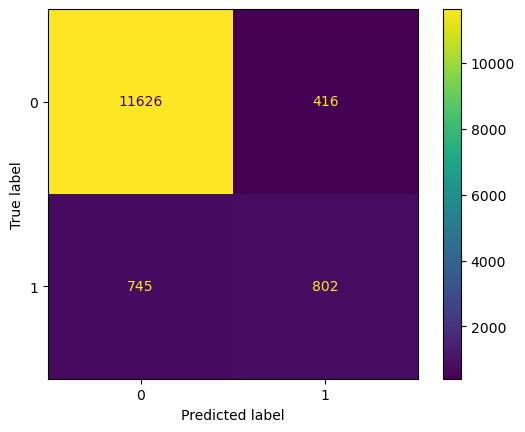

In [18]:
predictions = dt_search.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=lr_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_search.classes_)
disp.plot()

plt.show()

### Are all the features important for this model?

Not all the features are needed when using the Decision Tree Classifier

CPU times: total: 859 ms
Wall time: 1.21 s


Text(0.5, 0, 'Permutation Importance')

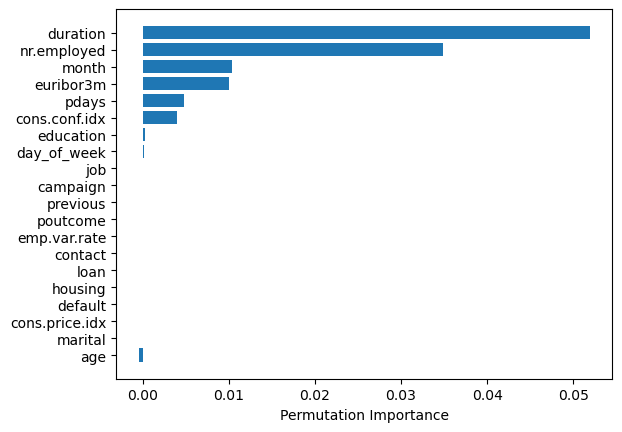

In [19]:
%%time
perm_importance = permutation_importance(dt_search, X_test, y_test)

# Plotting the importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### We can improve the results with Xgboost

That is one of the best classifier.

In [20]:
%%time
model = xgb.XGBClassifier(
    device="cuda",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    learning_rate=0.5,
    subsample=1,
#    colsample_bytree=0.60,
#    colsample_bylevel=0.35,
#    colsample_bynode=0.45,
    min_child_weight=20,
    #gamma=0.7,
#    reg_alpha=1.15,
    reg_lambda=0.25,
    max_depth=10,
    n_estimators=200,
    random_state=42,
    tree_method = 'hist',
#    min_split_loss = 20,
)

# Training the model on the training data
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=3,
    verbose=True,
)

print(model)

[0]	validation_0-auc:0.93526
[1]	validation_0-auc:0.94021
[2]	validation_0-auc:0.94267
[3]	validation_0-auc:0.94403
[4]	validation_0-auc:0.94435
[5]	validation_0-auc:0.94442
[6]	validation_0-auc:0.94501
[7]	validation_0-auc:0.94529
[8]	validation_0-auc:0.94528
[9]	validation_0-auc:0.94534
[10]	validation_0-auc:0.94558
[11]	validation_0-auc:0.94564
[12]	validation_0-auc:0.94554
[13]	validation_0-auc:0.94515
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=20, miss

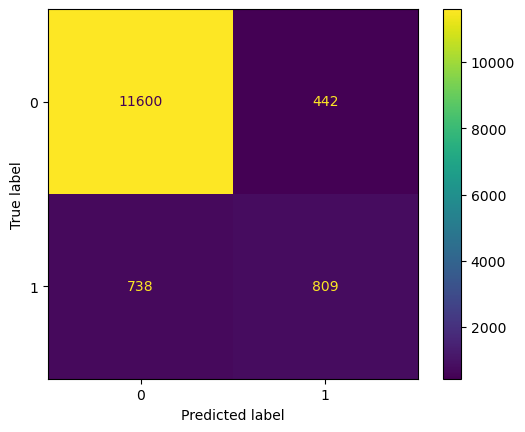

In [21]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=lr_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_search.classes_)
disp.plot()

plt.show()

The f1 score of the Xgboost model is 58% same as the DT model

In [22]:
from sklearn.metrics import classification_report
labels = ['0', '1']
print(classification_report(y_test, predictions, target_names=labels))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     12042
           1       0.65      0.52      0.58      1547

    accuracy                           0.91     13589
   macro avg       0.79      0.74      0.76     13589
weighted avg       0.91      0.91      0.91     13589



Almost all features have a contribution on with this model as we can see on the following plot.

CPU times: total: 26.4 s
Wall time: 879 ms


Text(0.5, 0, 'Permutation Importance')

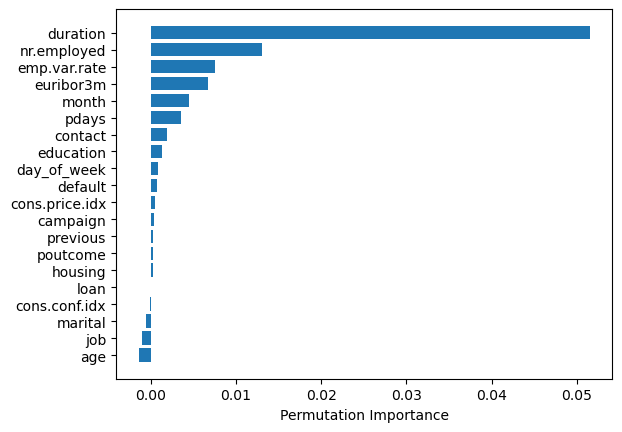

In [23]:
%%time
perm_importance = permutation_importance(model, X_test, y_test)

# Plotting the importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#### Reducing the features by using the correlation

Some features have low correlation to the target

In [24]:
def corr_plot(df):
    corr = df.select_dtypes(exclude=['category']).corr()
    w = len(corr)
    h = int(w * 0.8)
    _, ax = plt.subplots(figsize = (w, h))
    sns.heatmap(corr, ax = ax, vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')

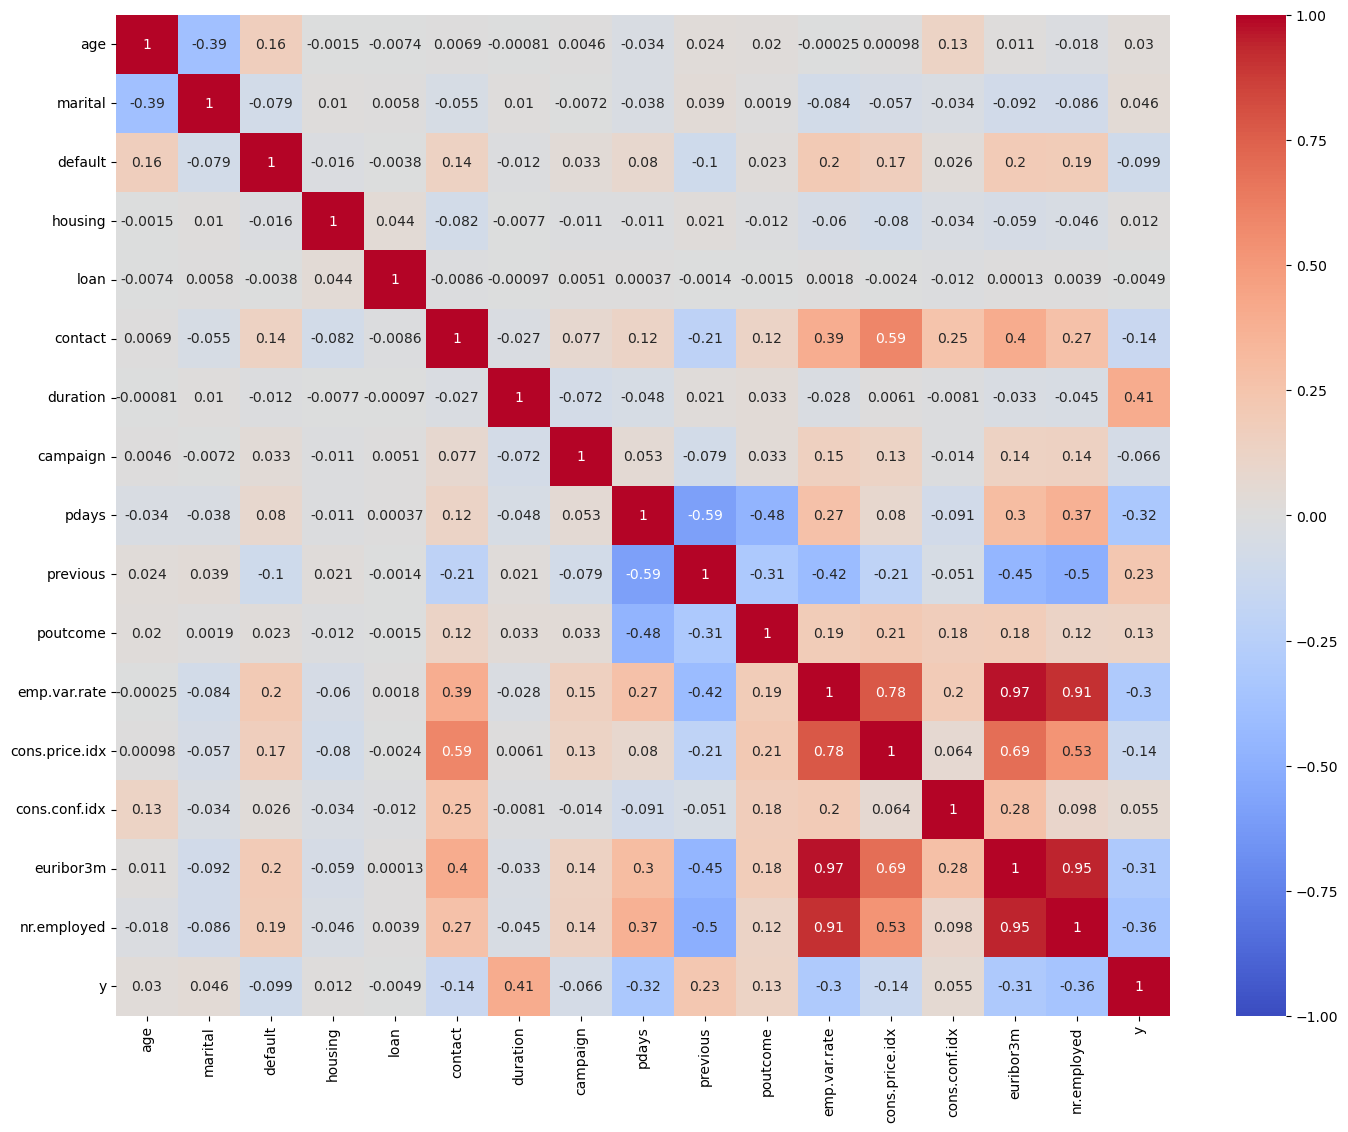

In [25]:
corr_plot(df)

What happens if we remove 3 of the features with lower correlation?

In [26]:
#X = df.drop(['y','age','marital','housing','loan'], axis=1)
X = df.drop(['y','age','marital','housing'], axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = .33)

In [27]:
%%time
model2 = xgb.XGBClassifier(
#    device="cuda",
    objective='binary:logistic',
    enable_categorical=True,
    eval_metric='auc',
    learning_rate=0.1,
    subsample=0.8,
#    colsample_bytree=0.60,
#    colsample_bylevel=0.35,
#    colsample_bynode=0.45,
    min_child_weight=20,
    #gamma=0.7,
#    reg_alpha=1.15,
    reg_lambda=0.25,
    max_depth=10,
    n_estimators=200,
    random_state=42,
    tree_method = 'hist',
#    min_split_loss = 20,
)

# Training the model on the training data
model2.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=3,
    verbose=True,
)

print(model)

[0]	validation_0-auc:0.93814
[1]	validation_0-auc:0.94058
[2]	validation_0-auc:0.94216
[3]	validation_0-auc:0.94247
[4]	validation_0-auc:0.94284
[5]	validation_0-auc:0.94331
[6]	validation_0-auc:0.94322
[7]	validation_0-auc:0.94392
[8]	validation_0-auc:0.94401
[9]	validation_0-auc:0.94416
[10]	validation_0-auc:0.94474
[11]	validation_0-auc:0.94488
[12]	validation_0-auc:0.94508
[13]	validation_0-auc:0.94509
[14]	validation_0-auc:0.94542
[15]	validation_0-auc:0.94539
[16]	validation_0-auc:0.94536
[17]	validation_0-auc:0.94551
[18]	validation_0-auc:0.94568
[19]	validation_0-auc:0.94578
[20]	validation_0-auc:0.94588
[21]	validation_0-auc:0.94607
[22]	validation_0-auc:0.94621
[23]	validation_0-auc:0.94623
[24]	validation_0-auc:0.94632
[25]	validation_0-auc:0.94638
[26]	validation_0-auc:0.94642
[27]	validation_0-auc:0.94651
[28]	validation_0-auc:0.94663
[29]	validation_0-auc:0.94659
[30]	validation_0-auc:0.94667
[31]	validation_0-auc:0.94681
[32]	validation_0-auc:0.94686
[33]	validation_0-au

That gives a slighly better result

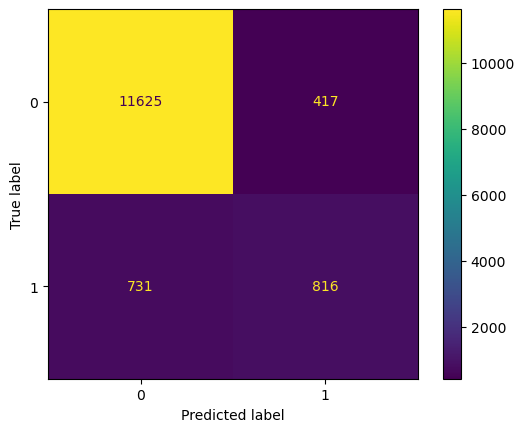

In [28]:
predictions = model2.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=lr_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_search.classes_)
disp.plot()

plt.show()

The f1 score has increased to 59% from 58% earlier

In [29]:
print(classification_report(y_test, predictions, target_names=labels))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     12042
           1       0.66      0.53      0.59      1547

    accuracy                           0.92     13589
   macro avg       0.80      0.75      0.77     13589
weighted avg       0.91      0.92      0.91     13589



CPU times: total: 22.1 s
Wall time: 751 ms


Text(0.5, 0, 'Permutation Importance')

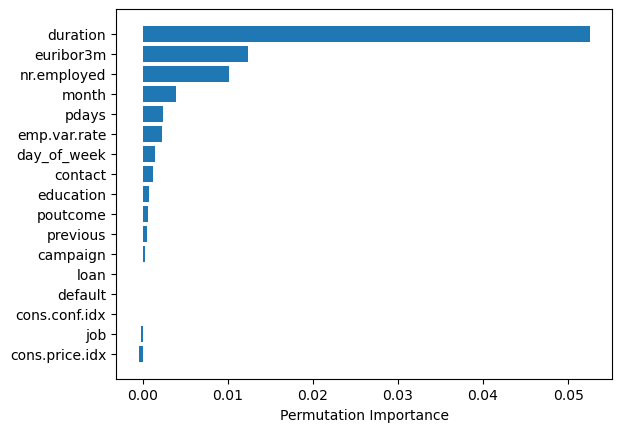

In [30]:
%%time
perm_importance = permutation_importance(model2, X_test, y_test)

# Plotting the importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [34]:
#resampling the data
df_s = df.sample(frac=1, random_state=42)
df_t = df_s.loc[df_s['y'] == 1]
df_f = df_s.loc[df_s['y'] == False][:df_t.shape[0]]
#Concat
normal_distributed_df = pd.concat([df_t, df_f])
#sample
new_df = normal_distributed_df.sample(frac=1, random_state=42)

#### The most important features

All model have one thing in commun, the duration of the call is a key feature for determining if the call is successfull.

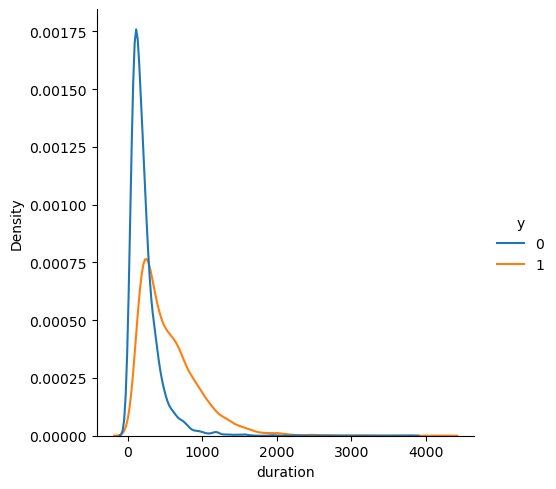

In [35]:
sns.displot(data=new_df, x="duration", hue="y", kind="kde")
plt.show()

What about the month?

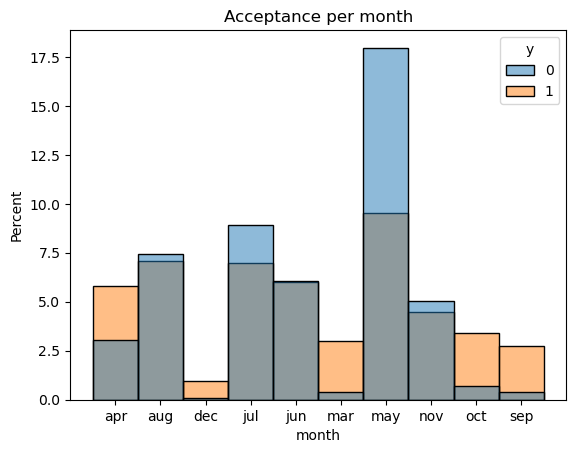

In [36]:
ax = sns.histplot(data=new_df, x="month", hue="y",stat="percent")
ax.set_title('Acceptance per month')
plt.show()

Do not call on Monday or Friday

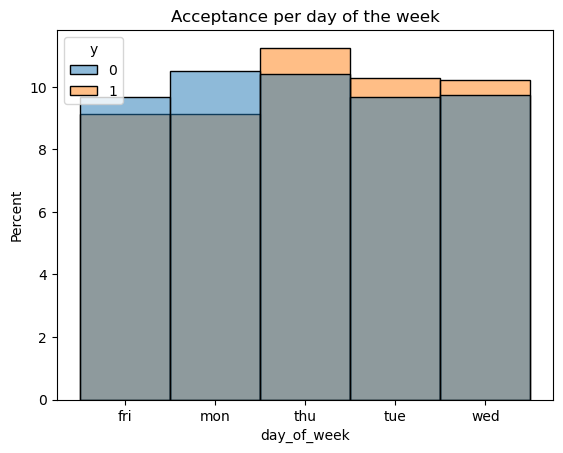

In [37]:
ax = sns.histplot(data=new_df, x="day_of_week", hue="y",stat="percent")
ax.set_title('Acceptance per day of the week')
plt.show()

What accupations give positive outcome?

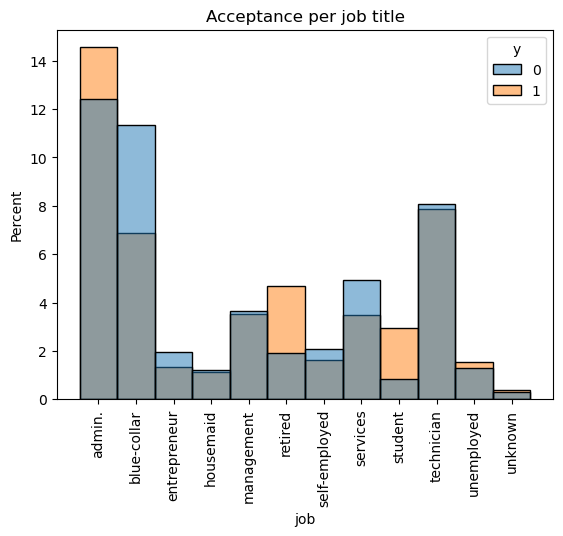

In [38]:
ax = sns.histplot(data=new_df, x="job", hue="y",stat="percent")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Acceptance per job title')
plt.show()

How does the education level affect the outcome?

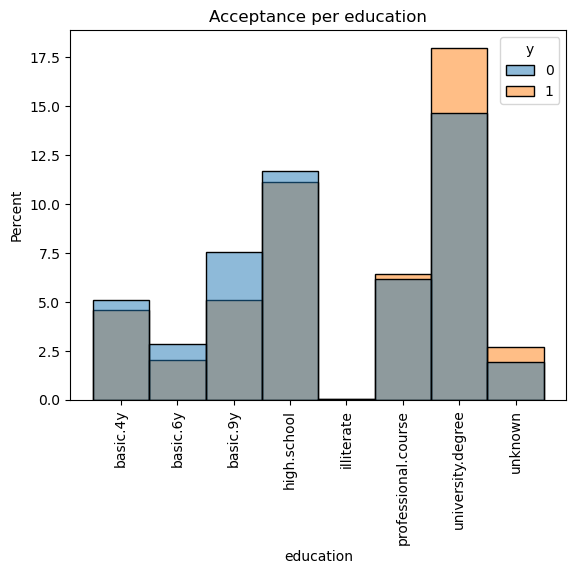

In [39]:
ax = sns.histplot(data=new_df, x="education", hue="y",stat="percent")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Acceptance per education')
plt.show()

### Conclusions

The more time you spend on the phone, the more likely the person will subscribe. Call when people are available to talk. The months of march, april, september, october and december are more favorable. Do not call on Monday or Friday. Retiries, admin and students are more likely to subscribe. An university degree is a good indicator of acceptance.